## Traditional Methods of Feature engineering and ML

In [17]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score,
    f1_score,
    precision_score,
    recall_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [11]:
def load_processed_data(filepath):
    df = pd.read_csv(filepath)
    df['created_at'] = pd.to_datetime(df['created_at'])
    df['source'] = df['source'].astype('category')
    df['platform_community'] = df['platform_community'].astype('category')
    df['sentiment_label'] = df['sentiment_label'].astype('category')
    return df

df = load_processed_data('../data/final_df.csv')

In [12]:
df.dtypes

text                                     object
text_length                               int64
sentiment_compound                      float64
sentiment_positive                      float64
sentiment_negative                      float64
sentiment_neutral                       float64
sentiment_subjectivity                  float64
sentiment_label                        category
likes                                     int64
replies                                   int64
created_at                  datetime64[ns, UTC]
source                                 category
source_id                                object
platform_post_id                         object
platform_post_title                      object
platform_community                     category
platform_post_score                       int64
platform_post_engagement                  int64
contains_ai                                bool
contains_opinion                           bool
contains_societal                       

### Tf-idf Vectorization

In [13]:
# Initialize TF-IDF vectorizer
tfidf = TfidfVectorizer(
    max_features=5000,      # Keep top 5000 words
    min_df=5,               # Word must appear in at least 5 documents
    max_df=0.8,             # Ignore words in more than 80% of documents
    ngram_range=(1, 2),     # Use unigrams and bigrams
    strip_accents='unicode',
    lowercase=True,
    stop_words='english'
)

# Fit and transform the text
X = tfidf.fit_transform(df['text_tfidf'])

print(f"✓ TF-IDF shape: {X.shape}")
print(f"  Features (vocabulary size): {X.shape[1]}")
print(f"  Samples: {X.shape[0]}")

✓ TF-IDF shape: (2985, 3531)
  Features (vocabulary size): 3531
  Samples: 2985


In [16]:
# Encode target
le = LabelEncoder()
y = le.fit_transform(df['sentiment_label'])

# Save mapping for later interpretation
label_mapping = dict(zip(le.transform(le.classes_), le.classes_))
print(f"\n✓ Label encoding:")
print(f"  Classes: {le.classes_}")
print(f"  Mapping: {label_mapping}")
print(f"  Class distribution: {np.bincount(y)}")


# Split data 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # Keep class proportions
)

print(f"\n✓ Train/Test Split:")
print(f"  Training samples: {X_train.shape[0]}")
print(f"  Test samples: {X_test.shape[0]}")
print(f"  Training shape: {X_train.shape}")
print(f"  Test shape: {X_test.shape}")

# Check class balance
print(f"\n✓ Class balance in training set:")
unique, counts = np.unique(y_train, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"  {le.classes_[cls]}: {count} ({count/len(y_train)*100:.1f}%)")


✓ Label encoding:
  Classes: ['negative' 'neutral' 'positive']
  Mapping: {np.int64(0): 'negative', np.int64(1): 'neutral', np.int64(2): 'positive'}
  Class distribution: [ 906   88 1991]

✓ Train/Test Split:
  Training samples: 2388
  Test samples: 597
  Training shape: (2388, 3531)
  Test shape: (597, 3531)

✓ Class balance in training set:
  negative: 725 (30.4%)
  neutral: 70 (2.9%)
  positive: 1593 (66.7%)


### Logistic Regression

In [18]:
# Train model
start_time = time.time()
lr_model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',  # Handle class imbalance
    random_state=42,
    n_jobs=-1  # Use all CPU cores
)

lr_model.fit(X_train, y_train)
train_time = time.time() - start_time

# Predictions
y_pred_lr = lr_model.predict(X_test)

# Evaluation
accuracy_lr = accuracy_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr, average='weighted')

print(f"\n⏱️  Training Time: {train_time:.2f} seconds")
print(f"✓ Accuracy: {accuracy_lr:.4f}")
print(f"✓ F1-Score (weighted): {f1_lr:.4f}")

print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred_lr, target_names=le.classes_))

print("\n📈 Confusion Matrix:")
cm_lr = confusion_matrix(y_test, y_pred_lr)
print(cm_lr)


⏱️  Training Time: 3.35 seconds
✓ Accuracy: 0.7454
✓ F1-Score (weighted): 0.7461

📊 Classification Report:
              precision    recall  f1-score   support

    negative       0.62      0.67      0.64       181
     neutral       0.27      0.22      0.24        18
    positive       0.83      0.80      0.82       398

    accuracy                           0.75       597
   macro avg       0.57      0.56      0.57       597
weighted avg       0.75      0.75      0.75       597


📈 Confusion Matrix:
[[121   1  59]
 [  7   4   7]
 [ 68  10 320]]


### Linear SVC

In [19]:
# Train model
start_time = time.time()
svc_model = SVC(
    kernel='linear',  # Linear kernel works well for text
    class_weight='balanced',
    random_state=42,
    max_iter=1000
)

svc_model.fit(X_train, y_train)
train_time = time.time() - start_time

# Predictions
y_pred_svc = svc_model.predict(X_test)

# Evaluation
accuracy_svc = accuracy_score(y_test, y_pred_svc)
f1_svc = f1_score(y_test, y_pred_svc, average='weighted')

print(f"\n⏱️  Training Time: {train_time:.2f} seconds")
print(f"✓ Accuracy: {accuracy_svc:.4f}")
print(f"✓ F1-Score (weighted): {f1_svc:.4f}")

print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred_svc, target_names=le.classes_))

print("\n📈 Confusion Matrix:")
cm_svc = confusion_matrix(y_test, y_pred_svc)
print(cm_svc)


c:\Users\Archi\CMSE830\.venv\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(



⏱️  Training Time: 0.94 seconds
✓ Accuracy: 0.6382
✓ F1-Score (weighted): 0.6438

📊 Classification Report:
              precision    recall  f1-score   support

    negative       0.46      0.88      0.60       181
     neutral       0.40      0.11      0.17        18
    positive       0.90      0.55      0.68       398

    accuracy                           0.64       597
   macro avg       0.59      0.52      0.49       597
weighted avg       0.75      0.64      0.64       597


📈 Confusion Matrix:
[[160   1  20]
 [ 12   2   4]
 [177   2 219]]


### Random Forest

In [20]:
# Train model
start_time = time.time()
rf_model = RandomForestClassifier(
    n_estimators=100,  # Number of trees
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,  # Use all CPU cores
    max_depth=50,  # Limit depth to prevent overfitting
    min_samples_split=5
)

rf_model.fit(X_train, y_train)
train_time = time.time() - start_time

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluation
accuracy_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')

print(f"\n⏱️  Training Time: {train_time:.2f} seconds")
print(f"✓ Accuracy: {accuracy_rf:.4f}")
print(f"✓ F1-Score (weighted): {f1_rf:.4f}")

print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))

print("\n📈 Confusion Matrix:")
cm_rf = confusion_matrix(y_test, y_pred_rf)
print(cm_rf)


⏱️  Training Time: 0.42 seconds
✓ Accuracy: 0.6750
✓ F1-Score (weighted): 0.6685

📊 Classification Report:
              precision    recall  f1-score   support

    negative       0.49      0.48      0.48       181
     neutral       0.75      0.17      0.27        18
    positive       0.75      0.79      0.77       398

    accuracy                           0.68       597
   macro avg       0.66      0.48      0.51       597
weighted avg       0.67      0.68      0.67       597


📈 Confusion Matrix:
[[ 87   0  94]
 [  7   3   8]
 [ 84   1 313]]


### Model Comparison

In [21]:
# Create comparison table
comparison_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'SVC', 'Random Forest'],
    'Accuracy': [accuracy_lr, accuracy_svc, accuracy_rf],
    'F1-Score': [f1_lr, f1_svc, f1_rf]
})

comparison_df = comparison_df.sort_values('Accuracy', ascending=False)
print("\n", comparison_df.to_string(index=False))

# Find best model
best_model_name = comparison_df.iloc[0]['Model']
best_accuracy = comparison_df.iloc[0]['Accuracy']

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   Accuracy: {best_accuracy:.4f}")


               Model  Accuracy  F1-Score
Logistic Regression  0.745394  0.746143
      Random Forest  0.675042  0.668494
                SVC  0.638191  0.643835

🏆 Best Model: Logistic Regression
   Accuracy: 0.7454



✓ Saved: confusion_matrices_comparison.png


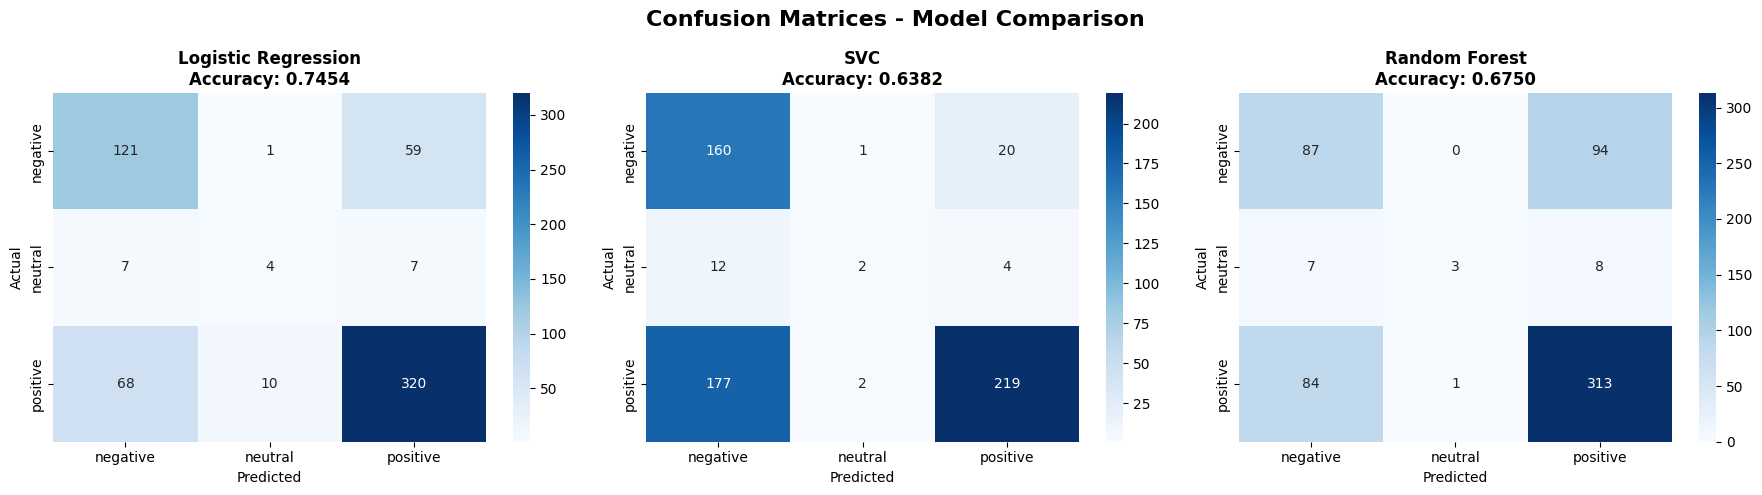

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Confusion Matrices - Model Comparison', fontsize=16, fontweight='bold')

models = [
    ('Logistic Regression', cm_lr, accuracy_lr),
    ('SVC', cm_svc, accuracy_svc),
    ('Random Forest', cm_rf, accuracy_rf)
]

for idx, (name, cm, acc) in enumerate(models):
    ax = axes[idx]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=le.classes_, 
                yticklabels=le.classes_,
                ax=ax, cbar=True)
    ax.set_title(f'{name}\nAccuracy: {acc:.4f}', fontweight='bold')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.savefig('confusion_matrices_comparison.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: confusion_matrices_comparison.png")
plt.show()


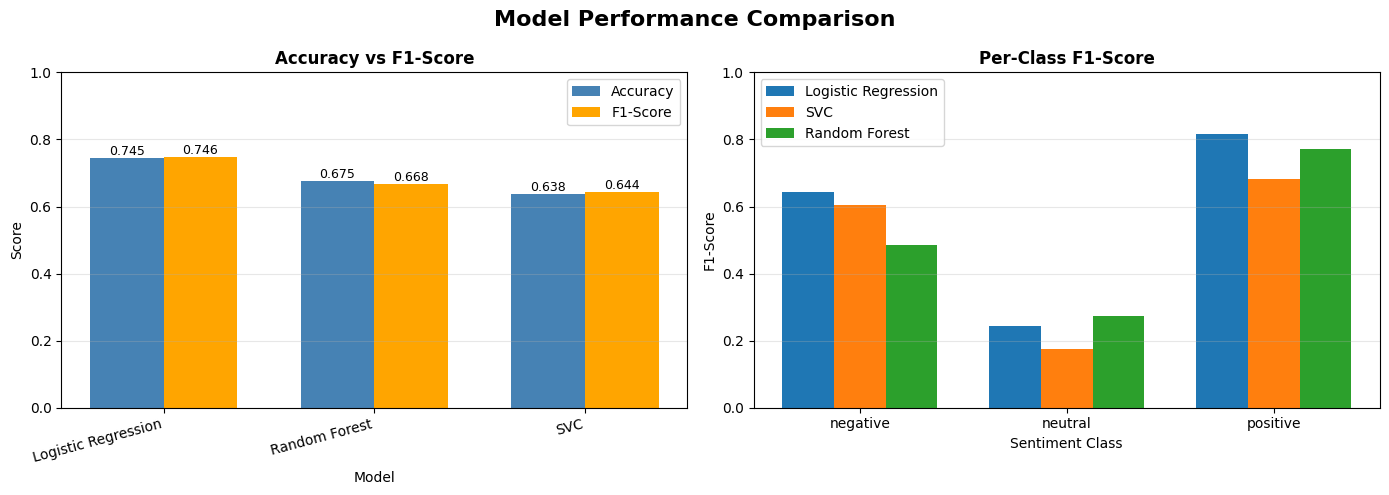

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

# 1. Accuracy and F1-Score Comparison
ax = axes[0]
x = np.arange(len(comparison_df))
width = 0.35

bars1 = ax.bar(x - width/2, comparison_df['Accuracy'], width, 
               label='Accuracy', color='steelblue')
bars2 = ax.bar(x + width/2, comparison_df['F1-Score'], width, 
               label='F1-Score', color='orange')

ax.set_xlabel('Model')
ax.set_ylabel('Score')
ax.set_title('Accuracy vs F1-Score', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Model'], rotation=15, ha='right')
ax.legend()
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# 2. Per-Class Performance (F1-Score)
ax = axes[1]

# Calculate per-class F1 scores
f1_per_class = {
    'Logistic Regression': f1_score(y_test, y_pred_lr, average=None),
    'SVC': f1_score(y_test, y_pred_svc, average=None),
    'Random Forest': f1_score(y_test, y_pred_rf, average=None)
}

x = np.arange(len(le.classes_))
width = 0.25

for idx, (model_name, scores) in enumerate(f1_per_class.items()):
    offset = (idx - 1) * width
    ax.bar(x + offset, scores, width, label=model_name)

ax.set_xlabel('Sentiment Class')
ax.set_ylabel('F1-Score')
ax.set_title('Per-Class F1-Score', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(le.classes_)
ax.legend()
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
# plt.savefig('model_performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


✓ Saved: feature_importance.png


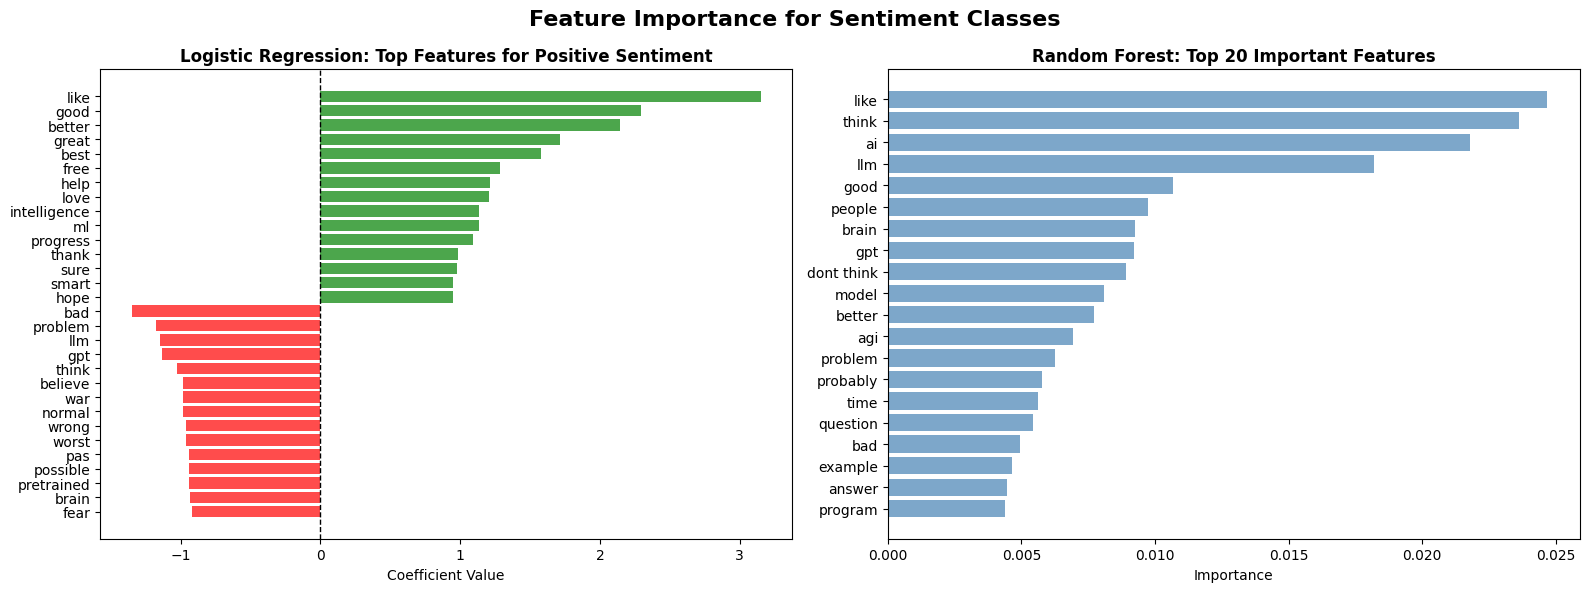


🔍 TOP POSITIVE SENTIMENT INDICATORS (Logistic Regression):
  like: 3.1489
  good: 2.2954
  better: 2.1405
  great: 1.7135
  best: 1.5756
  free: 1.2819
  help: 1.2112
  love: 1.2054
  intelligence: 1.1343
  ml: 1.1324

🔍 TOP NEGATIVE SENTIMENT INDICATORS (Logistic Regression):
  bad: -1.3500
  problem: -1.1755
  llm: -1.1498
  gpt: -1.1352
  think: -1.0274
  believe: -0.9855
  war: -0.9807
  normal: -0.9799
  wrong: -0.9642
  worst: -0.9631


In [24]:
# Get feature names from TF-IDF vectorizer
feature_names = np.array(tfidf.get_feature_names_out())

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Feature Importance for Sentiment Classes', fontsize=16, fontweight='bold')

# 1. Logistic Regression Coefficients (for positive class)
ax = axes[0]
# Get coefficients for positive class (class 2)
positive_coef_idx = 2
coef = lr_model.coef_[positive_coef_idx]
top_positive_idx = np.argsort(coef)[-15:][::-1]
top_negative_idx = np.argsort(coef)[:15]

top_features = np.concatenate([feature_names[top_positive_idx], 
                                feature_names[top_negative_idx]])
top_coef = np.concatenate([coef[top_positive_idx], 
                           coef[top_negative_idx]])

colors = ['green' if c > 0 else 'red' for c in top_coef]
ax.barh(range(len(top_features)), top_coef, color=colors, alpha=0.7)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features)
ax.set_xlabel('Coefficient Value')
ax.set_title('Logistic Regression: Top Features for Positive Sentiment', fontweight='bold')
ax.axvline(x=0, color='black', linestyle='--', linewidth=1)
ax.invert_yaxis()

# 2. Random Forest Feature Importance
ax = axes[1]
importances = rf_model.feature_importances_
top_idx = np.argsort(importances)[-20:][::-1]

ax.barh(range(len(top_idx)), importances[top_idx], color='steelblue', alpha=0.7)
ax.set_yticks(range(len(top_idx)))
ax.set_yticklabels(feature_names[top_idx])
ax.set_xlabel('Importance')
ax.set_title('Random Forest: Top 20 Important Features', fontweight='bold')
ax.invert_yaxis()

plt.tight_layout()
# plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# Print top features
print("\n🔍 TOP POSITIVE SENTIMENT INDICATORS (Logistic Regression):")
for feature, coef_val in zip(feature_names[top_positive_idx[:10]], coef[top_positive_idx[:10]]):
    print(f"  {feature}: {coef_val:.4f}")

print("\n🔍 TOP NEGATIVE SENTIMENT INDICATORS (Logistic Regression):")
for feature, coef_val in zip(feature_names[top_negative_idx[:10]], coef[top_negative_idx[:10]]):
    print(f"  {feature}: {coef_val:.4f}")